---

# <center> Regularized Linear Regression Deep Dive </center> 
<center>Prepared by Wyatt Walsh</center>

---

This notebook analyzes the application of ordinary least squares (OLS), Ridge regression, the Lasso, and the Elastic Net to a wine quality prediction dataset with an emphasis on the underlying optimization mathematics of the regression techniques and corresponding Python implementations. 

The dataset is briefly explored and analyzed for use in future modeling. Next, model estimators or algorithmic updates are derived for each model, and implementations in Python are discussed. Each model is then fitted to the dataset (with K-Fold cross-validation used to identify model hyperparameters for the regularized cases) and fitted model coefficients as well as algorithm run-times are compared with Scikit-Learn. Additionally, visualizations are generated of the model coefficient paths for Ridge regression and the Lasso. 

Implementations presented here performed on par with Scikit-Learn, either performing faster or with lower error on the considered dataset. 

The wine quality dataset was obtained through the final class project for Engineering Statistics, Quality Control, and Forecasting (IEOR 165) at UC Berkeley. 

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Establish-Modeling-Data" data-toc-modified-id="Establish-Modeling-Data-1">Establish Modeling Data</a></span><ul class="toc-item"><li><span><a href="#Make-Necessary-Imports-and-Configurations" data-toc-modified-id="Make-Necessary-Imports-and-Configurations-1.1">Make Necessary Imports and Configurations</a></span></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-1.2">Import Data</a></span></li><li><span><a href="#Train-Test-Data-Splitting" data-toc-modified-id="Train-Test-Data-Splitting-1.3">Train Test Data Splitting</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1.4">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Variable-Summarization-and-Ensuring-Data-Cleanliness" data-toc-modified-id="Variable-Summarization-and-Ensuring-Data-Cleanliness-1.4.1">Variable Summarization and Ensuring Data Cleanliness</a></span></li><li><span><a href="#Evaluation-for-Multicollinearity-between-Features" data-toc-modified-id="Evaluation-for-Multicollinearity-between-Features-1.4.2">Evaluation for Multicollinearity between Features</a></span><ul class="toc-item"><li><span><a href="#Scatterplot-Matrix" data-toc-modified-id="Scatterplot-Matrix-1.4.2.1">Scatterplot Matrix</a></span></li><li><span><a href="#Correlation-Heatmap" data-toc-modified-id="Correlation-Heatmap-1.4.2.2">Correlation Heatmap</a></span></li><li><span><a href="#VIF-Calculation" data-toc-modified-id="VIF-Calculation-1.4.2.3">VIF Calculation</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2">Modeling</a></span><ul class="toc-item"><li><span><a href="#Ordinary-Least-Squares" data-toc-modified-id="Ordinary-Least-Squares-2.1">Ordinary Least Squares</a></span><ul class="toc-item"><li><span><a href="#Deriving-the-Ordinary-Least-Squares-Estimator" data-toc-modified-id="Deriving-the-Ordinary-Least-Squares-Estimator-2.1.1">Deriving the Ordinary Least Squares Estimator</a></span></li><li><span><a href="#Implementation-in-Python" data-toc-modified-id="Implementation-in-Python-2.1.2">Implementation in Python</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-2.1.3">Comparisons with Scikit-Learn</a></span></li></ul></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-2.2">Ridge Regression</a></span><ul class="toc-item"><li><span><a href="#Deriving-the-Ridge-Estimator" data-toc-modified-id="Deriving-the-Ridge-Estimator-2.2.1">Deriving the Ridge Estimator</a></span></li><li><span><a href="#Implementation-in-Python" data-toc-modified-id="Implementation-in-Python-2.2.2">Implementation in Python</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-2.2.3">Comparisons with Scikit-Learn</a></span></li><li><span><a href="#Coefficient-Path-Visualization" data-toc-modified-id="Coefficient-Path-Visualization-2.2.4">Coefficient Path Visualization</a></span></li></ul></li><li><span><a href="#The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)" data-toc-modified-id="The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)-2.3">The Lasso (Least Absolute Shrinkage and Selection Operator)</a></span><ul class="toc-item"><li><span><a href="#Solving-the-Lasso" data-toc-modified-id="Solving-the-Lasso-2.3.1">Solving the Lasso</a></span></li><li><span><a href="#Implementation-in-Python" data-toc-modified-id="Implementation-in-Python-2.3.2">Implementation in Python</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-2.3.3">Comparisons with Scikit-Learn</a></span></li><li><span><a href="#Coefficient-Path-Visualization" data-toc-modified-id="Coefficient-Path-Visualization-2.3.4">Coefficient Path Visualization</a></span></li></ul></li><li><span><a href="#The-Elastic-Net" data-toc-modified-id="The-Elastic-Net-2.4">The Elastic Net</a></span><ul class="toc-item"><li><span><a href="#Solving-the-Elastic-Net" data-toc-modified-id="Solving-the-Elastic-Net-2.4.1">Solving the Elastic Net</a></span></li><li><span><a href="#Implementation-in-Python" data-toc-modified-id="Implementation-in-Python-2.4.2">Implementation in Python</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-2.4.3">Comparisons with Scikit-Learn</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3">Conclusion</a></span></li></ul></div>

---

## Establish Modeling Data

### Make Necessary Imports and Configurations

In [1]:
# Libraries to load and prepare data
import numpy as np
import pandas as pd

# Custom libraries for utilities, modeling, cross-validation, and visualization
from src import utilities as utils, linear_regression as lr, cross_validation as cv, visualization

# Plotting library and Jupyter configuration
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 50
pd.set_option("display.precision", 4)

### Import Data

In [2]:
# Import winequality-red.csv within the data directory into a Pandas dataframe and display beginning rows
wine_data_raw = pd.read_csv('data/winequality-red.csv', sep=';', dtype=np.float64)
display(wine_data_raw.head())
print('This dataset contains {} features, {} outcome ({}), and {} samples'.
      format(len(wine_data_raw.columns[0:-1]), 1, wine_data_raw.columns[-1],
             len(wine_data_raw)))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


This dataset contains 11 features, 1 outcome (quality), and 1599 samples


### Train Test Data Splitting

In [3]:
train_proportion = 0.8  # Define proportion of data in the training set
train, test = utils.test_train_split(wine_data_raw, train_proportion)

# Convert to NumPy and parse X, y columns from datasets
train_vals, test_vals = train.to_numpy(), test.to_numpy() 
X_train = train_vals[:, 0:-1]
y_train = train_vals[:, [-1]]
X_test = test_vals[:, 0:-1]
y_test = test_vals[:, [-1]]

# Display training and testing sets and print number of rows in each
print('With a training proportion of {}: \n'.format(train_proportion))
print('the training set contains {} samples:'.format(len(train)))
display(train.head())
print('and the test set contains {} samples:'.format(len(test)))
display(test.head())

With a training proportion of 0.8: 

the training set contains 1279 samples:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6.0
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5.0
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6.0
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5.0
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6.0


and the test set contains 320 samples:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.28,0.44,1.8,0.081,28.0,68.0,0.9950,3.36,0.66,11.2,5.0
1,7.0,0.50,0.14,1.8,0.078,10.0,23.0,0.9964,3.53,0.61,10.4,5.0
2,6.0,0.50,0.00,1.4,0.057,15.0,26.0,0.9945,3.36,0.45,9.5,5.0
3,8.0,0.59,0.05,2.0,0.089,12.0,32.0,0.9973,3.36,0.61,10.0,5.0
4,6.5,0.53,0.06,2.0,0.063,29.0,44.0,0.9949,3.38,0.83,10.3,6.0


[Back to Top](#Table-of-Contents)

### Exploratory Data Analysis

Now that the data has been prepared for future modeling, exploratory data analysis (EDA) is conducted on the training data (to avoid data leakage).

This process consists of:

- Summarization of variables to better understand their values and ensure data cleanliness
- Scatterplot matrix creation to evaluate relationships betweeen predictors
- Correlation heatmap creation to evaluate possible multicollinearity between predictors
- Variance Inflation Factor analysis to also evaluate multicollinearity between predictors 

These methods should help to better characterize the dataset in order to properly model and rationalize model outputs.

#### Variable Summarization and Ensuring Data Cleanliness

In [4]:
display(pd.DataFrame(train.nunique(axis=0), columns=['Unique Value Count']).T)
display(
    pd.DataFrame(train.isna().sum(), columns=['Number of Missing Values']).T)
display(train.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Unique Value Count,94,138,78,86,146,58,142,395,87,90,61,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Number of Missing Values,0,0,0,0,0,0,0,0,0,0,0,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000,1279.0000
mean,8.3239,0.5269,0.2699,2.5310,0.0879,15.7776,46.3620,0.9968,3.3106,0.6573,10.3967,5.6357
std,1.7537,0.1804,0.1917,1.4442,0.0481,10.4134,33.0939,0.0019,0.1553,0.1650,1.0683,0.8147
min,4.6000,0.1200,0.0000,0.9000,0.0120,1.0000,6.0000,0.9901,2.8600,0.3300,8.4000,3.0000
25%,7.1000,0.3900,0.1000,1.9000,0.0700,7.0000,22.0000,0.9956,3.2100,0.5500,9.5000,5.0000
50%,7.9000,0.5200,0.2500,2.2000,0.0790,13.0000,37.0000,0.9968,3.3100,0.6200,10.1000,6.0000
75%,9.2000,0.6375,0.4200,2.6000,0.0910,21.0000,62.0000,0.9978,3.4000,0.7300,11.1000,6.0000
max,15.9000,1.5800,0.7900,15.5000,0.6110,72.0000,289.0000,1.0037,4.0100,1.9800,14.9000,8.0000


Thankfully the dataset has no missing values and thus no need for data imputation.

#### Evaluation for Multicollinearity between Features

Multicollinearity arises when there is significant interdependence found amongst the predictors and can have a negative impact when modelling. Thus, multicollinearity is assesed through evaluation of a scatterplot matrix (please be patient with this function as all predictors are numerical and thus a large matrix is produced), a numerical feature correlation heatmap, as well as variance inflation factor (VIF) measurement. 

##### Scatterplot Matrix


<Figure size 1000x500 with 0 Axes>

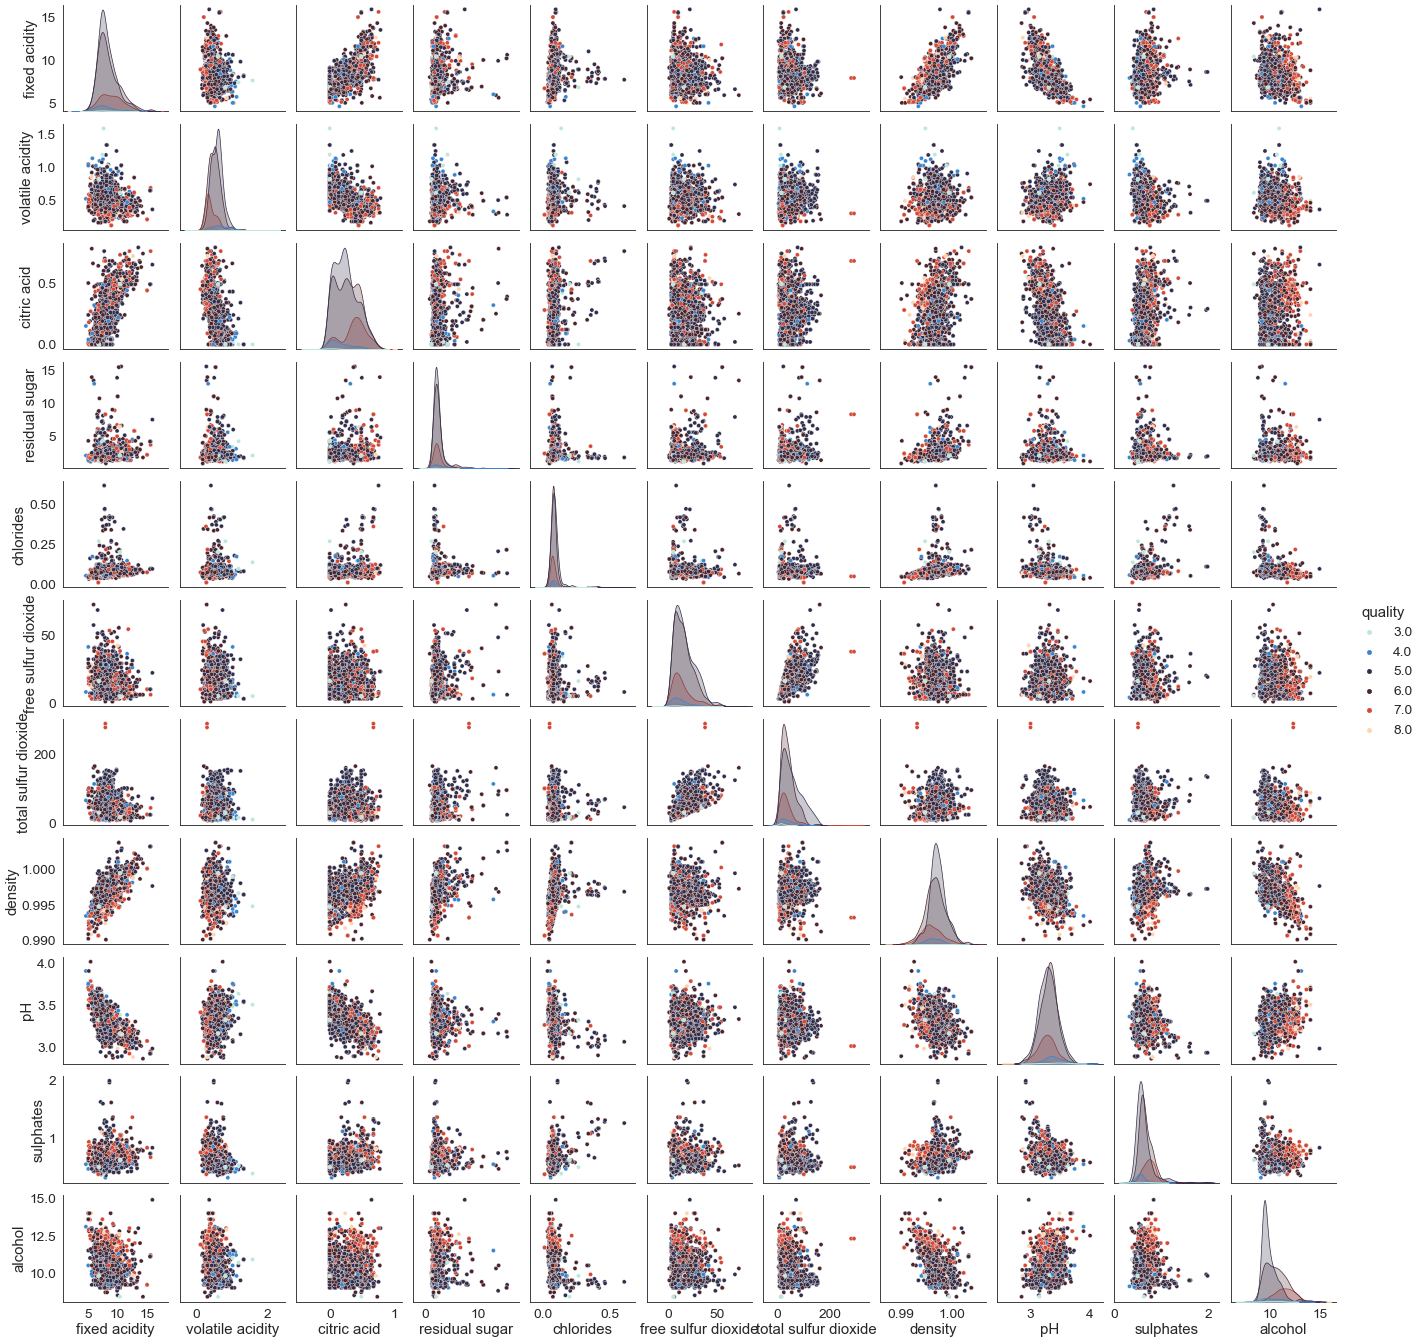

In [5]:
plt.figure(figsize=(20, 10))
visualization.scatter_matrix(train)

It seems that multicollinearity is low for this dataset as most of the scatterplots seem patternless. However, further analysis should be conducted to ensure this finding.

##### Correlation Heatmap

Text(0.5, 1.0, 'Numerical Feature Correlation Heatmap')

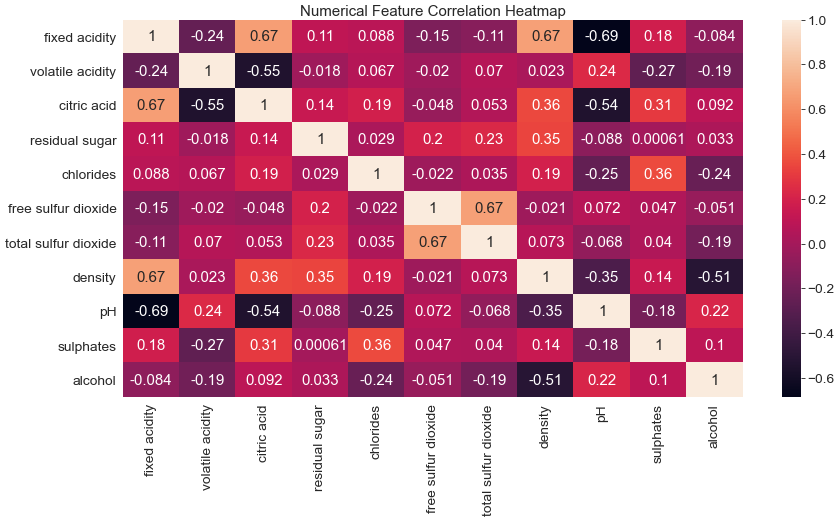

In [6]:
plt.figure(figsize=(20, 10))
visualization.correlation_heatmap(train)

It appears that the highest correlation value is -0.69 found between fixed acidity and pH followed by 0.67 found between fixed acidity and citric acid, fixed acidity and density and free sulfur dioxide and total sulfur dioxide. This value isn't incredibly high, but VIF analysis should determine if this is significant. 

##### VIF Calculation



In [7]:
utils.VIF(train)

Low Multicollinearity Detected (All VIF Scores Less Than Five


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,3.0739,1.7531,3.0586,1.1014,1.4605,1.9793,2.2318,-0.0052,2.2678,1.3496,1.3222


Since the result for all features is less than five, VIF analysis establishes the absence of significant multicollinearity for this dataset

[Back to Top](#Table-of-Contents)

## Modeling

In a linear regression model, a continuous response (or outcome) is modeled as a linear function of its features (or predictors): 

$$y_i = \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} + \ldots + \beta_px_{i,p} + \epsilon_i \space \forall \space i \in \{1, \ldots, n\}$$

where $p$ is the number of features, $n$ is the number of samples, and $\epsilon$ is an error term with zero-mean and finite variance. In vector notation:

$$ \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}$$

where $\mathbf{y}$ is a response vector $ [y_1, y_2, ..., y_n]^\mathbf{T}$ of length $n$ , $\mathbf{X}$ is a $n \times (p + 1)$ design matrix of features $[\mathbf{1}, \mathbf{x_1}, \mathbf{x_2}, ..., \mathbf{x_p}]$, and $\mathbf{\beta}$ is a length $(p + 1)$ coefficient vector $[\beta_0, \beta_1, \beta_2, ..., \beta_p]$. In this formulation, a column of ones is appended to the design matrix, $\mathbf{X}$ to include $\beta_0$ as an intercept term.

The goal of linear regression is to use sample data to find estimates of the model coefficients, $\hat{\mathbf{\beta}}$, such that the coefficients may be used to predict responses given new feature data. Finding these model coefficient estimates requires the use of optimization, since the best coefficients will arise when a consideration for the error between predicted values and actual values is minimized. 

$\hat{y_i} = \sum_{j = 1}^p x_{i, j}\hat{\beta}_j  $, a model prediction for sample $i$,  has an error (or residual) defined as the difference between the actual value and the prediction: $y_i - \hat{y_i}$. 

Thus, the total error of all predictions can be found through summation of each prediction's error: $\sum_{i = 1}^{n} (y_i - \hat{y_i}) = \sum_{i = 1}^{n} (y_i - \sum_{j = 1}^p x_{i, j}\hat{\beta}_j)$. 

In vector notation, model predictions can be found as: $ \hat{\mathbf{y}} = \mathbf{X}\hat{\mathbf{\beta}}$ with total error: $\| \mathbf{y} - \hat{\mathbf{y}} \|_2$

However, this error is not practical for optimization, since errors of opposite signs will cancel out producing an objective function value of zero when error is in fact much larger. This can be remedied through squaring the model's resultant prediction error producing the sum of squared error:  $\sum_{i = 1}^{n} (y_i - \hat{y_i})^2 = \sum_{i = 1}^{n} (y_i - \sum_{j = 1}^p x_{i, j}\hat{\beta}_j)^2$ or in vector notation $\| \mathbf{y} - \hat{\mathbf{y}} \|_2^2$. An optimization problem solving the sum of squared error is called a least squares problem.

Ordinary least squares (OLS) regression (multiple linear regression) solves the least squares problem through optimizing the squared error loss function to produce a model estimator (found analytically) that generates a best-fit line across sample data predicting model outcomes. 

However, the predictive capability of an OLS model can be hampered by overfitting the training set data. Since our modeling data is a sample taken from an overall population, and furthermore our training data a subsample of this sample, error (noise) can be introduced by idiosyncrasies unique to the sample. When training on such a sample, a model can become overfit when it uses patterns and relationships found within the sample, but not within the underlying population, to make its predictions. This results in a predictive model with high variance (parameter predictions vary greatly from sample to sample) and low bias (error introduced by the modelling technique), which is sub-optimal in its predictive capabilities. 

One possible way to improve performance in this case is to reduce variance by adding bias to the model. For the case of OLS, this can be achieved through biasing parameter predictions towards zero (shrinkage). Ridge regression, the Lasso, and the Elastic Net all apply different types of shrinkage through the addition of a certain coefficient penalty term to the least squares problem. 

Model estimators can be derived analytically for the cases of OLS and Ridge regression. However, for the cases of the Lasso and the Elastic net, the loss function penalty terms are not well-behaved thus a discrete optimization technique is required to solve for the model coefficient estimates. Discrete optimization techniques, like the popular Gradient Descent algorithm, conduct a search through an objective function's feasible region for optimal objective function values. For the Lasso and the Elastic net, Pathwise Coordinate Descent is the algorithm of choice. This algorithm essentially updates a coordinate at a time, leaving all others constant. Iterative updates for the algorithm for both cases are derived within their corresponding sections. 

Read each section below for model-specific derivations and discussion. 

<center>
    <br>
    <big>
    <a href=#Ordinary-Least-Squares>Ordinary Least Squares</a> · 
    <a href=#Ridge-Regression>Ridge Regression</a> · 
    <a href=#The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)>the Lasso</a> ·
    <a href=#The-Elastic-Net>the Elastic Net</a> 
    </big>
    <br><br><br>
</center>


### Ordinary Least Squares

#### Deriving the Ordinary Least Squares Estimator

The Ordinary Least Squares (OLS)  loss function is the sum of squared error:

$$ L(\mathbf{\beta}) = \|\mathbf{y} - \hat{\mathbf{y}}\|_2^2 =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2$$

Furthermore, this problem can now be formalized as a least squares optimization problem, which serves to derive estimates for the model parameters, $\mathbf{\beta}$, that minimize the sum of squared error between actual and predicted values of the outcome: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \frac{1}{2n}  \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} $$

A factor of $\frac{1}{2}$ is added to simplify solving the gradient. A factor of $\frac{1}{n}$ is added in order to allow the objective function to converge to the expected value of the error by the law of large numbers. Aided by the problem's unconstrained nature, a closed-form solution for the OLS estimator can be derived by setting the gradient of the loss function (objective) equal to zero and solving the resultant equation, which produces:

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{y}) $$

To show that this solution is the unique (global) minimizer to the OLS problem, it will suffice to show that the loss function (3) is convex. Second-order convexity conditions state that a function is convex if it is continuous, twice differentiable, and has an associated  Hessian matrix that is positive semi-definite. 

Due to its quadratic nature, the OLS loss function (3) is both continuous and twice differentiable. To establish the last second-order condition, the Hessian matrix of the OLS loss function (3) is found as: 

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} $$

Furthermore, this Hessian matrix can be shown to be positive semi-definite as:

$$ \mathbf{\beta}^T (2\mathbf{X}^T\mathbf{X}) \beta = 2(\mathbf{X}\beta)^T \mathbf{X}\beta = 2 \|\mathbf{X}\mathbf{\beta}\|_2^2 \succeq 0 \: \: \: \forall \: \: \: \mathbf{\beta}$$

Thus, by the second-order conditions for convexity, the OLS loss function (3) is convex. 

Therefore, any local minimum of this function is also a global minimum, which implies that the OLS estimator found above (5) is the unique minimizer to the least squares (OLS) regression problem.

#### Implementation in Python

Solving for the OLS estimator using the matrix inverse does not scale well, thus the NumPy function `solve`, which employs the LAPACK `_gesv` routine, is used to find the least squares solution. This function solves the equation $Ax = b$ in the case where A is square ($X^TX$) and full-rank (linearly independent columns), which is our case (full-rank being established through VIF analysis). However, in the case that A is not full-rank, then the function `lstsq` should be used, which utilizes the xGELSD routine and thus finds the singular value decomposition of A.

A possible implementation in Python of OLS with an optional intercept term is:

```python
def ols(X, y, fit_intercept=True):
    """Ordinary Least Squares (OLS) Regression model with intercept term.
    Fits an OLS regression model using the closed-form OLS estimator equation.
    Intercept term is included via design matrix augmentation.

    Params:
        X - NumPy matrix, size (N, p), of numerical predictors
        y - NumPy array, length N, of numerical response
        fit_intercept - Boolean indicating whether to include an intercept term

    Returns:
        NumPy array, length p + 1, of fitted model coefficients
    """
    m, n = np.shape(X)
    if fit_intercept:
        X = np.hstack((np.ones((m, 1)), X))
    return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
```

#### Comparisons with Scikit-Learn

Comparison runtimes, errors, and model parameters outputs between the above implementation and Scikit-Learn can be found below:

In [8]:
utils.compare(X_train, y_train, test_vals, list(train.columns[0:-1]), lr.ols)

,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.0007,112.0262,22.4645,0.0065,-0.952,-0.0861,0.0096,-1.9237,0.0049,-0.0036,-17.4434,-0.6592,0.9859,0.2692
Scikit-Learn's Function,0.0027,112.0262,22.4645,0.0065,-0.952,-0.0861,0.0096,-1.9237,0.0049,-0.0036,-17.4434,-0.6592,0.9859,0.2692


---

### Ridge Regression

#### Deriving the Ridge Estimator

The Ridge loss function is similar to the OLS loss function (3) but with the addition of an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_2^2 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Ridge problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \frac{1}{2n} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_2^2 $$

A closed-form solution can be analytically derived for the Ridge estimator similarly to the OLS case:

$$ {\hat {\beta }}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y} $$

This estimator can be shown to be unique similarly to the OLS case. First, the Hessian matrix is computed:

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} + 2 \lambda \mathbf {I}$$

Next, this matrix is shown to be positive definite, implying strong convexity, as:

$$ \mathbf{\beta}^T (\mathbf{X}^T\mathbf{X} + \lambda \mathbf {I})\mathbf{\beta} = (\mathbf{X}\mathbf{\beta})\mathbf{X}\mathbf{\beta} + \lambda \mathbf{\beta}^T\mathbf{\beta} = \|\mathbf{X}\mathbf{\beta}\|_2^2 + \lambda \|\mathbf{\beta}\|_2^2 \succ 0 \: \: \: \forall \:\:\:  \mathbf{\beta} \neq \mathbf{0}$$

Establishing that the Ridge loss function is strongly convex implies that the Ridge estimator is the unique minimizer to the Ridge problem (10)

However, the OLS solution ($ \hat{\mathbf{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{y}) $) can also be used by reformulating the problem through data augmentation: 

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\mathbf{\beta}}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert \begin{bmatrix}\mathbf{Y} \\ 0 \end{bmatrix}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \\
                                                            0 & \lambda \cdot \mathbf{I} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \mathbf{\beta}\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

Note: $\lambda = 0$ produces the OLS estimate. Furthermore, features should be centered and scaled to unit variance to enable fair parameter shrinkage.

#### Implementation in Python 

A possible way to implement the Ridge estimator in Python is given below with similar considerations for computing the matrix inverse as the OLS case: 

```python
def ridge(X, y, l2):
    """Ridge Regression model with intercept term.
    L2 penalty and intercept term included via design matrix augmentation.
    This augmentation allows for the OLS estimator to be used for fitting.

    Params:
        X - NumPy matrix, size (N, p), of numerical predictors
        y - NumPy array, length N, of numerical response
        l2 - L2 penalty tuning parameter (positive scalar) 

    Returns:
        NumPy array, length p + 1, of fitted model coefficients
    """
    m, n = np.shape(X)
    upper_half = np.hstack((np.ones((m, 1)), X))
    lower = np.zeros((n, n))
    np.fill_diagonal(lower, np.sqrt(l2))
    lower_half = np.hstack((np.zeros((n, 1)), lower))
    X = np.vstack((upper_half, lower_half))
    y = np.append(y, np.zeros(n))
    return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
```

#### Comparisons with Scikit-Learn

First, the features are standardized, then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 500 values between 1e-6 and 50000 on a log scale.

In [9]:
ridge_cv = cv.ridge(X_train, y_train, num_lambdas=500, k=5)
lambda_star_ridge = ridge_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_ridge)
utils.compare(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), model=lr.ridge, l=lambda_star_ridge)

Optimal tuning parameter value:  81.5949328936461


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.0004,112.3172,5.6357,0.0356,-0.1618,-0.0008,0.0202,-0.0861,0.0402,-0.1082,-0.0611,-0.075,0.1558,0.2571
Scikit-Learn's Function,0.0013,112.3172,5.6357,0.0356,-0.1618,-0.0008,0.0202,-0.0861,0.0402,-0.1082,-0.0611,-0.075,0.1558,0.2571


#### Coefficient Path Visualization

A plot of the coefficient paths with increasing values of the $L_2$ tuning parameter is produced below. It can be seen that as the tuning parameter value increases, all coefficient values are shrunk towards zero as expected.

Text(0.5, 1.0, 'Ridge Coefficient Paths')

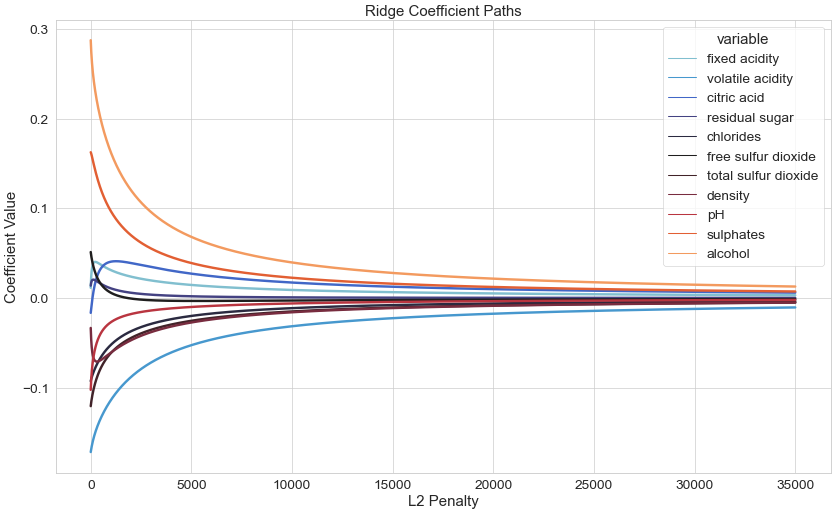

In [10]:
plt.figure(figsize=(20, 12))
visualization.ridge_plot(X_train,
                         y_train,
                         num_lambdas=5000,
                         features=list(train.columns[0:-1]))

---

### The Lasso (Least Absolute Shrinkage and Selection Operator)

#### Solving the Lasso

The Lasso loss function is similar to the OLS loss function (3) but with the addition of an $L_1$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_1 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

which has the effect of bringing model parameters to zero for a large enough value of the associated tuning parameter. In other words, this penalty performs automated feature selection since possibly some of the model parameters will be brought to zero.  

The Lasso problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \frac{1}{2n} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_1 $$

Unlike the previous models, no closed-form solution exists due to the fact that the loss function is no longer continuously differentiable (non-smooth absolute component). Thus, discrete optimization techniques are needed to solve for the parameter estimates. Numerous algorithms, such as the LARS (Least Angle Regression) algorithm and the Forward Stepwise regression algorithm have been developed to solve the Lasso, however the Pathwise Coordinate Descent algorithm is leveraged here. 

Since the number of samples is much greater than the number of features in this case, covariance updates are used where cross-covariance terms are computed and stored for active variables. Warm starts, fitting a sequence of models ranging on a log scale from the maximum value of the tuning parameter down to a minimum value, are used to further speed up the convergence of the algorithm. 
 
Before beginning the algorithm, the predictor variables should be standardized to have zero mean and variance of one. From there, the algorithm can be initialized by setting the $p + 1$ length $\mathbf{\beta}$ coefficient vector to zero. Cycles are then computed across all the coefficients until convergence. Within each cycle, for each element of $\mathbf{\beta}$, an update is calculated and soft-thresholding is applied.

The simplest form of coordinate descent updates calculates simple least squares coefficients for each predictor using the partial residuals across all other predictors. Partial residuals in this case are found as: 

$$ r_{i,j} = y_i - \sum_{k \neq j} x_{i, k}\beta_k$$

Following, the simple least squares coefficient value of the residuals on the $j$th predictor is found as: 

$$\beta_j^* = \frac{1}{n}\sum_{i=1}^{n} x_{i, j}r_{i, j}$$

Soft-thresholding is then applied to this value and the penalty resulting in the $j$th coefficient update for a certain cycle: 

$$\beta_j = \mathbf{S}(\beta_j^*, \lambda) = sign(\beta_j^*)(\left|\beta_j^*\right| - \lambda)_+ =
  \begin{cases} 
      \beta_j^* - \lambda & \beta_j^* > 0 \text{ and } \lambda <  \left|\beta_j^*\right|\\
      \beta_j^* + \lambda & \beta_j^* > 0 \text{ and } \lambda < \left|\beta_j^*\right| \\
      0 & \lambda \geq  \left|\beta_j^*\right|
   \end{cases}
$$

Naive updates can be used for improved implementation where the simple least squares coefficient value  for the $j$th predictor is:

$$\beta_j^* = \frac{1}{n}\sum_{i=1}^{n} x_{i, j}r_i + \beta_j$$

where $r_i$ the current model residual. Further implementation improvements can be derived by using covariance updates instead. These are best used when the number of samples is much greater than the number of predictors. In this case, the first term of the above equation (19) can be replaced with:

$$\sum_{i=1}^{n} x_{i, j}r_i = \langle x_j, y \rangle - \sum_{k: \left|\beta_k\right| > 0} \langle x_j, x_k \rangle \beta_k$$

Finally, warm starts should be utilized where a sequence of models with tuning parameter values from $\lambda_{\text{max}}$ down to $\lambda_{\text{min}} = \epsilon\lambda_{\text{max}}$ on a log scale are fit, initializing the coefficients of each iteration to the solution of the last iteration. Typical values for $\epsilon$ and path length are 0.001 and 100 respectively. The value of $\lambda_{\text{max}}$ can be found by determining the parameter value for which all model coefficients will be zero. Thus, 

$$\lambda_{\text{max}} = \frac{\max_l \left|\langle x_l, y \rangle \right|}{n}$$

When applying warm starts, the algorithm is considered as pathwise coordinate descent. By having a starting place to begin the search for optimality, convergence can be sped up, raising the efficiency of the algorithm.

#### Implementation in Python

One possible way to implement pathwise coordinate descent for the Lasso (with options for tuning the convergence tolerance, path length, and returning the path) is:

```python
def lasso(X, y, l1, tol=1e-6, path_length=100, return_path=False):
    """The Lasso Regression model with intercept term.
    Intercept term included via design matrix augmentation.
    Pathwise coordinate descent with co-variance updates is applied.
    Path from max value of the L1 tuning parameter to input tuning parameter value.
    Features must be standardized (centered and scaled to unit variance)

    Params:
        X - NumPy matrix, size (N, p), of standardized numerical predictors
        y - NumPy array, length N, of numerical response
        l1 - L1 penalty tuning parameter (positive scalar)
        tol - Coordinate Descent convergence tolerance (exited if change < tol)
        path_length - Number of tuning parameter values to include in path (positive integer)
        return_path - Boolean indicating whether model coefficients along path should be returned

    Returns:
        if return_path == False:
            NumPy array, length p + 1, of fitted model coefficients
        if return_path == True:
            List, length 3, of last fitted model coefficients, tuning parameter path and coefficient values
    """
    X = np.hstack((np.ones((len(X), 1)), X))
    m, n = np.shape(X)
    B_star = np.zeros((n))
    l_max = max(list(abs(np.dot(np.transpose(X[:, 1:]), y)))) / m
    # At or above l_max, all coefficients (except intercept) will be brought to 0
    if l1 >= l_max:
        return np.append(np.mean(y), np.zeros((n - 1)))
    l_path = np.geomspace(l_max, l1, path_length)
    coeffiecients = np.zeros((len(l_path), n))
    for i in range(len(l_path)):
        while True:
            B_s = B_star
            for j in range(n):
                k = np.where(B_s != 0)[0]
                update = (1/m)*((np.dot(X[:,j], y)- \
                                np.dot(np.dot(X[:,j], X[:,k]), B_s[k]))) + \
                                B_s[j]
                B_star[j] = (np.sign(update) * max(abs(update) - l_path[i], 0))
            if np.all(abs(B_s - B_star) < tol):
                coeffiecients[i, :] = B_star
                break
    if return_path:
        return [B_star, l_path, coeffiecients]
    else:
        return B_star
```

#### Comparisons with Scikit-Learn

First, the features are standardized then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 500 values between 0.000001 and 1 on a log scale to enable a higher concentration of hyperparameters near zero to test via CV.

In [11]:
lasso_cv = cv.lasso(X_train, y_train, num_lambdas=500, k=5)
lambda_star_lasso = lasso_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_lasso)
utils.compare(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), model=lr.lasso, l=lambda_star_lasso)

Optimal tuning parameter value:  0.006849696716357447


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.1082,111.7438,5.6288,0.0,-0.1682,-0.0,0.0,-0.0827,0.0315,-0.0987,-0.0140,-0.0880,0.1494,0.2926
Scikit-Learn's Function,0.0018,111.9117,5.6357,0.0,-0.1675,-0.0,0.0,-0.0830,0.0329,-0.0997,-0.0145,-0.0883,0.1497,0.2924


#### Coefficient Path Visualization

A plot of the coefficient paths with increasing values of the  𝐿1  tuning parameter is produced below. It can be seen that as the tuning parameter value increases, coefficient values are brought to zero one by one. 

Text(0.5, 1.0, 'Lasso Coefficient Paths')

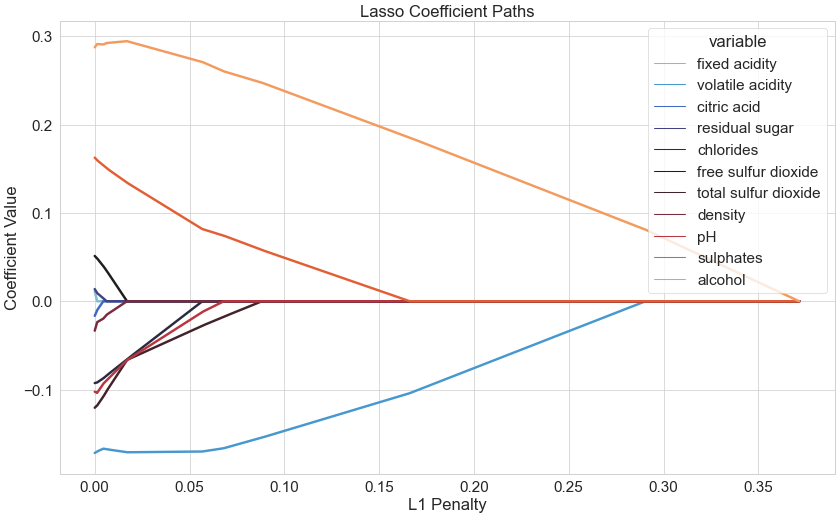

In [12]:
plt.figure(figsize=(20, 12))
visualization.lasso_plot(X_train,
                         y_train,
                         num_lambdas=5000,
                         features=list(train.columns[0:-1]))

---

### The Elastic Net

#### Solving the Elastic Net

The Elastic Net loss function is similar to the OLS loss function (3) but with the addition of an $L_1$ penalty and an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda [(1-\alpha)\frac{1}{2} \|\mathbf{\beta}\|_2^2 + \alpha \|\mathbf{\beta}\| ] \: \: \: \text{ with tuning parameters $\lambda \geq 0, 0 \leq \alpha \leq 1$  } $$

Having both $L_1$ and $L_2$ penalties, the Elastic Net serves to deliver a compromise between Ridge regression and the Lasso, bringing coefficients towards zero and selectively to zero. Cases where the number of features are much higher than the sample size and predictors are correlated in groups are the best cases in which to apply this model. Here, $\alpha$ can be considered as the parameter determining the ratio of L1 penalty to add, whereas $\lambda$ can be thought of as the intensity of regularization to apply. 

The Elastic Net problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}}  \frac{1}{2n}\|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda [(1-\alpha)\frac{1}{2} \|\mathbf{\beta}\|_2^2 + \alpha \|\mathbf{\beta}\| ]$$

Similarly to the Lasso, an intercept is included through design matrix augmentation and pathwise Coordinate Descent is implemented to solve since a closed-form solution does not exist due to the L1 penalty term. 

Pathwise coordinate descent is applied just as in the Lasso, but the $j$th coefficient value obtained after soft-thresholding is now found through: 

$$\beta_j = \frac{\mathbf{S}(\beta_j^*, \lambda\alpha)}{1 + \lambda(1-\alpha)} $$

The soft-thresholding operator is the same operator applied in the Lasso update: $sign(\beta_j^*)(\left|\beta_j^*\right| - \lambda\alpha)_+ $

Furthermore, covariance updates and warm starts can also be utilized for this case. For warm starts, $\lambda_{\text{max} }$ can be calculated as: 

$$\lambda_{\text{max}} = \frac{\max_l \left|\langle x_l, y \rangle \right|}{n\alpha}$$

#### Implementation in Python

One possible way to implement pathwise coordinate descent to solve the Elastic Net (with options for tuning the convergence tolerance, path length, and returning the path) is: 

```python
def elastic_net(X, y, l, alpha, tol=1e-4, path_length=100, return_path=False):
    """The Elastic Net Regression model with intercept term.
    Intercept term included via design matrix augmentation.
    Pathwise coordinate descent with co-variance updates is applied.
    Path from max value of the L1 tuning parameter to input tuning parameter value.
    Features must be standardized (centered and scaled to unit variance)

    Params:
        X - NumPy matrix, size (N, p), of standardized numerical predictors
        y - NumPy array, length N, of numerical response
        l1 - L1 penalty tuning parameter (positive scalar)
        l2 - L2 penalty tuning parameter (positive scalar)
        tol - Coordinate Descent convergence tolerance (exited if change < tol)
        path_length - Number of tuning parameter values to include in path (positive integer)

    Returns:
        NumPy array, length p + 1, of fitted model coefficients
    """
    X = np.hstack((np.ones((len(X), 1)), X))
    m, n = np.shape(X)
    B_star = np.zeros((n))
    if alpha == 0:
        l2 = 1e-15
    l_max = max(list(abs(np.dot(np.transpose(X), y)))) / m / alpha
    if l >= l_max:
        return np.append(np.mean(y), np.zeros((n - 1)))
    l_path = np.geomspace(l_max, l, path_length)
    for i in range(path_length):
        while True:
            B_s = B_star
            for j in range(n):
                k = np.where(B_s != 0)[0]
                update = (1/m)*((np.dot(X[:,j], y)- \
                                np.dot(np.dot(X[:,j], X[:,k]), B_s[k]))) + \
                                B_s[j]
                B_star[j] = (np.sign(update) * max(
                    abs(update) - l_path[i] * alpha, 0)) / (1 + (l_path[i] * (1 - alpha)))
            if np.all(abs(B_s - B_star) < tol):
                break
    return B_star
```

#### Comparisons with Scikit-Learn

First, the features are standardized then a grid of tuning parameters is tested via five-fold cross-validation (CV). This grid consists of 2500 combinations of tuning parameters with each having a log spaced grid of 50 values between 0.000001 and 1.

In [13]:
elastic_net_cv = cv.elastic_net(X_train, y_train, num_lambdas=50, k=5)
tuning_params_elastic_net = elastic_net_cv[-1]
print("Optimal lambda tuning parameter value: ", tuning_params_elastic_net[0], \
      " Optimal alpha tuning parameter value: ", tuning_params_elastic_net[1])
utils.compare(X_train, y_train, test_vals, features=list(train.columns[0:-1]), \
              model=lr.elastic_net, l=tuning_params_elastic_net[0], alpha=tuning_params_elastic_net[1])

Optimal lambda tuning parameter value:  1e-06  Optimal alpha tuning parameter value:  1.0


,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.2454,112.0284,5.6357,0.0113,-0.1716,-0.0165,0.0138,-0.0926,0.0513,-0.1205,-0.0332,-0.1024,0.1626,0.2875
Scikit-Learn's Function,0.0090,112.0262,5.6357,0.0115,-0.1716,-0.0165,0.0138,-0.0926,0.0513,-0.1205,-0.0333,-0.1023,0.1626,0.2875


---

## Conclusion

Upon analysis of the modeling results, it appears that the Lasso model should be selected since it results in a lower error on the test set. By performing feature selection and bringing multiple model coefficients to zero, the Lasso outperforms the other models showing high predictive abilities. 

[Back to Top](#Table-of-Contents)

---